In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import spacy
import sys
from sklearn.feature_extraction.text import CountVectorizer
from anchor import anchor_text
import time
from myUtils import *
import pickle
import matplotlib.pyplot as plt
import csv

In [2]:
# dataset from http://www.cs.cornell.edu/people/pabo/movie-review-data/
# Link: http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
def load_polarity(path='sentiment-sentences'):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            try:
                line.decode('utf8')
            except:
                continue
            data.append(line.strip())
            labels.append(l)
    return data, labels

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
data, labels = load_polarity()
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, test_size=.2, random_state=42)
train, val, train_labels, val_labels = sklearn.model_selection.train_test_split(train, train_labels, test_size=.1, random_state=42)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [5]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)
train_vectors = vectorizer.transform(train)
test_vectors = vectorizer.transform(test)
val_vectors = vectorizer.transform(val)

In [6]:
c = sklearn.linear_model.LogisticRegression()
# c = sklearn.ensemble.RandomForestClassifier(n_estimators=500, n_jobs=10)
c.fit(train_vectors, train_labels)
preds = c.predict(val_vectors)
print('Val accuracy', sklearn.metrics.accuracy_score(val_labels, preds))
def predict_lr(texts):
    return c.predict(vectorizer.transform(texts))

Val accuracy 0.7544910179640718


c:\users\alon\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False)

In [8]:
train.sort(key=lambda example: len(example))

In [14]:
with open("times.csv", "w") as time_file:
    writer = csv.writer(time_file)
    for i in range(0, len(train), 100):
        print(i)
        b = time.time()
        exp = explainer.explain_instance(train[i], predict_lr, threshold=0.95, verbose=False)
        writer.writerow([time.time() - b])
        time_file.flush()

0


In [19]:
with open('times.csv', newline='') as f:
    reader = csv.reader(f)
    predictions_time = list(reader)
 
indices = list(range(0, len(train), 100))
indices = indices[:len(predictions_time)]
texts_length = [len(train[i]) for i in indices]

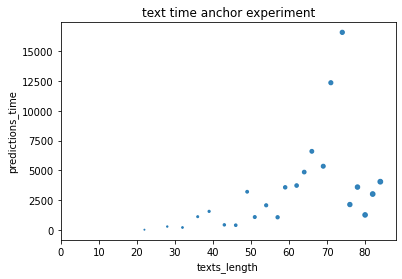

In [20]:
plt.scatter(texts_length, predictions_time, s = range(len(predictions_time)), alpha = 0.9)
plt.xlabel('texts_length')
plt.ylabel('predictions_time')
plt.title('text time anchor experiment')
plt.savefig("results/time.png")

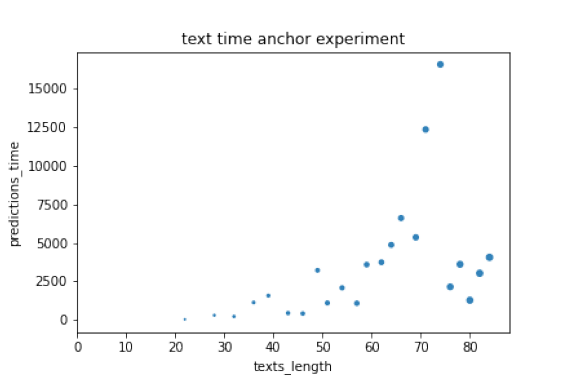

In [21]:
img = plt.imread("results/time.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)